In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hagrid-dataset/hand_landmarks_data.csv


# Install mediapipe

In [2]:
pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 15.4 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-core 1.34.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<4.0.0dev,>=3.19.5, but you have protobuf 4.25.6 which is incompatible.
google-cloud-bigtable 2.27.0 requires google-api-core[grpc]<3.0.0dev,>=2.16.0, but you have google-api-core 1.34.1 which is incompatible.
pandas-gbq 0.25.0 requires google-api-core<3.0.0dev,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible.
tensorflow-decision-forests 1.10.0 requires tensorflow==2.1

# Install scikeras

In [3]:
pip install scikeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 60.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


# Import Libraries


In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import joblib
from datetime import datetime
import mediapipe as mp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import save_model as save_keras_model

# Load the hand landmarks dataset


In [5]:
data_path = "/kaggle/input/hagrid-dataset/hand_landmarks_data.csv"
df = pd.read_csv(data_path)

# Extract features (landmark coordinates) and labels


In [6]:
X = df.iloc[:, :-1].values  # All columns except last
y = df.iloc[:, -1].values   # Last column is label

# Encode labels


In [7]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)
num_classes = len(le.classes_)

# Scale features


In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split dataset


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42)

# Reshape data for CNN (assuming 21 landmarks with x,y,z coordinates)


In [10]:
n_landmarks = 21
n_dimensions = 3
X_train_cnn = X_train.reshape(-1, n_landmarks, n_dimensions)
X_test_cnn = X_test.reshape(-1, n_landmarks, n_dimensions)
y_train_cnn = to_categorical(y_train, num_classes=num_classes)
y_test_cnn = to_categorical(y_test, num_classes=num_classes)

# CNN Model training approach


In [11]:
def create_and_train_cnn(X_train, y_train, X_test, y_test, input_shape=(n_landmarks, n_dimensions), num_classes=num_classes):
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    early_stopping = EarlyStopping(patience=3, restore_best_weights=True)
    history = model.fit(X_train, y_train, 
                       epochs=50, 
                       batch_size=32,
                       validation_data=(X_test, y_test),
                       callbacks=[early_stopping],
                       verbose=0)
    
    return model, history

# Initialize classifiers 


In [12]:
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Ridge Classifier": RidgeClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "SVM": SVC(probability=True),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(),
    "Extra Trees": ExtraTreesClassifier(),
    "Bagging": BaggingClassifier(),
    "MLP Neural Net": MLPClassifier(max_iter=1000),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "XGBoost": XGBClassifier(),
    "LightGBM": LGBMClassifier(verbose=-1),
    "CatBoost": CatBoostClassifier(verbose=0),
    "CNN": None 
}

# Train and evaluate classifiers


In [13]:
results = {}
for name, clf in classifiers.items():
    try:
        if name == "CNN":
            # Special handling for CNN
            cnn_model, cnn_history = create_and_train_cnn(X_train_cnn, y_train_cnn, X_test_cnn, y_test_cnn)
            y_pred = np.argmax(cnn_model.predict(X_test_cnn), axis=1)
            acc = accuracy_score(y_test, y_pred)
            results[name] = {
                "classifier": cnn_model,
                "accuracy": acc,
                "predict_proba": True,
                "history": cnn_history
            }
        elif clf is not None:
            # Train other models
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            acc = accuracy_score(y_test, y_pred)
            results[name] = {
                "classifier": clf,
                "accuracy": acc,
                "predict_proba": hasattr(clf, "predict_proba")
            }
        print(f"{name}: {acc:.4f}")
    except Exception as e:
        print(f"Error with {name}: {str(e)}")
        results[name] = {
            "classifier": None,
            "accuracy": 0,
            "predict_proba": False
        }

Logistic Regression: 0.9128
Ridge Classifier: 0.9042
Decision Tree: 0.6972
SVM: 0.8654
K-Nearest Neighbors: 0.6742
Naive Bayes: 0.3184
Random Forest: 0.8401
Extra Trees: 0.8411
Bagging: 0.7928
MLP Neural Net: 0.9821
Gradient Boosting: 0.8475
AdaBoost: 0.2115
XGBoost: 0.9258


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM: 0.9301
CatBoost: 0.9311


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
CNN: 0.9753


# Sort classifiers by accuracy


In [14]:
sorted_results = sorted(results.items(), key=lambda x: -x[1]['accuracy'])

# Show top 3 classifiers


In [15]:
top1_name, top1_data = sorted_results[0]
top2_name, top2_data = sorted_results[1]
top3_name, top3_data = sorted_results[2]

print(f"\nTop 1 Classifier: {top1_name} ({top1_data['accuracy']:.4f})")
print(f"Top 2 Classifier: {top2_name} ({top2_data['accuracy']:.4f})")
print(f"Top 3 Classifier: {top3_name} ({top3_data['accuracy']:.4f})")


Top 1 Classifier: MLP Neural Net (0.9821)
Top 2 Classifier: CNN (0.9753)
Top 3 Classifier: CatBoost (0.9311)


# Visualize classifier performance


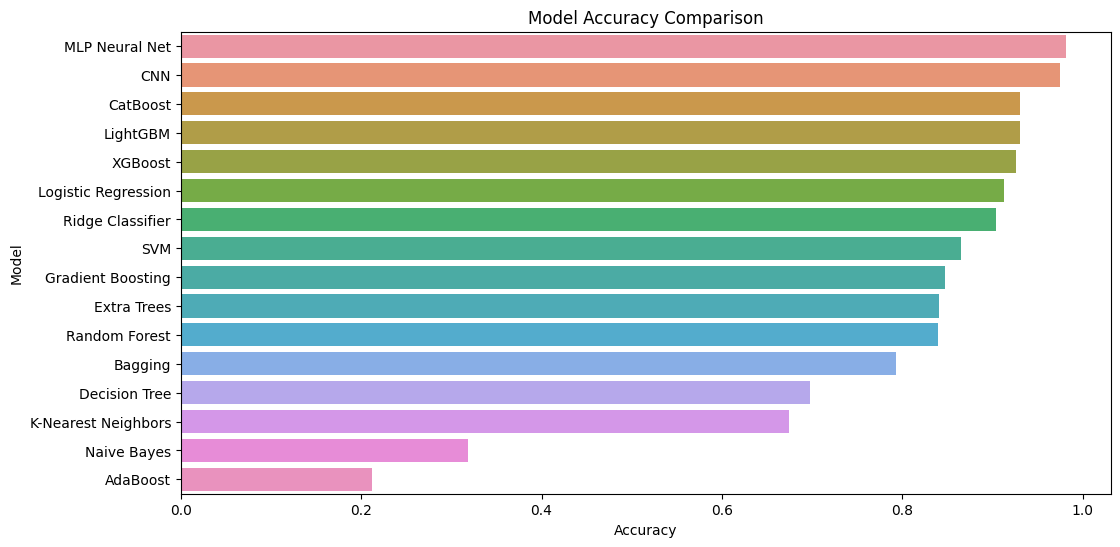

In [16]:
acc_df = pd.DataFrame([(k, v['accuracy']) for k, v in results.items()], columns=['Model', 'Accuracy'])
plt.figure(figsize=(12, 6))
sns.barplot(data=acc_df.sort_values(by='Accuracy', ascending=False), 
            x='Accuracy',
            y='Model')
plt.title('Model Accuracy Comparison')
plt.show()

# Create directory if it doesn't exist to save models


In [17]:
save_dir = "saved_models"
os.makedirs(save_dir, exist_ok=True)
    
# Get current timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
for name, data in results.items():
        if data['classifier'] is not None:
            # Clean model name for filename
            clean_name = name.replace(' ', '_').replace('-', '_')
            
            # Handle different model types
            if name == "CNN":
                # Keras model - save as .h5
                filename = os.path.join(save_dir, f"{clean_name}_{timestamp}.h5")
                save_keras_model(data['classifier'], filename)  # Use the imported name
            else:
                # Scikit-learn model - save as .pkl
                filename = os.path.join(save_dir, f"{clean_name}_{timestamp}.pkl")
                joblib.dump(data['classifier'], filename)
            
            print(f"Saved {name} model to {filename}")

Saved Logistic Regression model to saved_models/Logistic_Regression_20250408_004616.pkl
Saved Ridge Classifier model to saved_models/Ridge_Classifier_20250408_004616.pkl
Saved Decision Tree model to saved_models/Decision_Tree_20250408_004616.pkl
Saved SVM model to saved_models/SVM_20250408_004616.pkl
Saved K-Nearest Neighbors model to saved_models/K_Nearest_Neighbors_20250408_004616.pkl
Saved Naive Bayes model to saved_models/Naive_Bayes_20250408_004616.pkl
Saved Random Forest model to saved_models/Random_Forest_20250408_004616.pkl
Saved Extra Trees model to saved_models/Extra_Trees_20250408_004616.pkl
Saved Bagging model to saved_models/Bagging_20250408_004616.pkl
Saved MLP Neural Net model to saved_models/MLP_Neural_Net_20250408_004616.pkl
Saved Gradient Boosting model to saved_models/Gradient_Boosting_20250408_004616.pkl
Saved AdaBoost model to saved_models/AdaBoost_20250408_004616.pkl
Saved XGBoost model to saved_models/XGBoost_20250408_004616.pkl
Saved LightGBM model to saved_mode

# Plot CNN training history


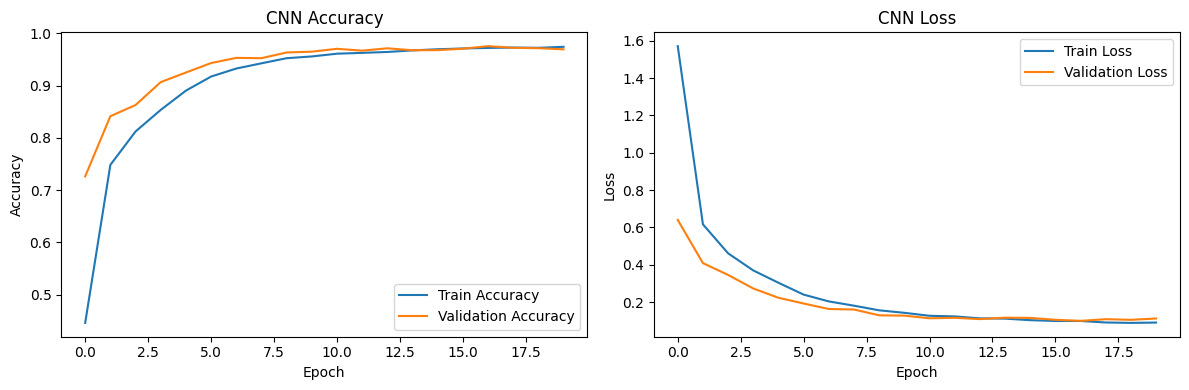

In [18]:
if 'CNN' in results and 'history' in results['CNN']:
    history = results['CNN']['history']
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('CNN Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('CNN Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Initialize MediaPipe Hands


In [19]:
mp_hands = mp.solutions.hands
hands = mp_hands.Hands()
mp_drawing = mp.solutions.drawing_utils

# Extract Landmarks


In [20]:
def extract_landmarks(hand_landmarks, frame_shape=None):
    """Extract and normalize landmarks from MediaPipe results"""
    landmarks = []
    for lm in hand_landmarks.landmark:
        landmarks.extend([lm.x, lm.y, lm.z])
    return np.array(landmarks)

# Use to start video capture of the best 2 Models


In [21]:
'''
cap = cv2.VideoCapture(0)
cv2.namedWindow('Top Prediction')
cv2.namedWindow('Second Best Prediction')

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame = cv2.flip(frame, 1)
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    result = hands.process(rgb_frame)

    if result.multi_hand_landmarks:
        for hand_landmarks in result.multi_hand_landmarks:
            mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)
            landmarks = extract_landmarks(hand_landmarks).reshape(1, -1)
            landmarks_scaled = scaler.transform(landmarks)
            
            # Reshape for CNN if needed
            landmarks_cnn = landmarks_scaled.reshape(1, n_landmarks, n_dimensions)

            # Get predictions from top 2 classifiers
            predictions = []
            for i, (name, data) in enumerate([(top1_name, top1_data), (top2_name, top2_data)]):
                if data['classifier'] is None:
                    continue
                    
                if name == "CNN":
                    if data['predict_proba']:
                        probs = data['classifier'].predict(landmarks_cnn)[0]
                        pred_class = np.argmax(probs)
                        confidence = probs[pred_class]
                        pred_label = le.inverse_transform([pred_class])[0]
                else:
                    if data['predict_proba']:
                        probs = data['classifier'].predict_proba(landmarks_scaled)[0]
                        pred_class = np.argmax(probs)
                        confidence = probs[pred_class]
                        pred_label = le.inverse_transform([pred_class])[0]
                    else:
                        pred_class = data['classifier'].predict(landmarks_scaled)[0]
                        confidence = 1.0  # Assume 100% confidence if no probabilities
                        pred_label = le.inverse_transform([pred_class])[0]
                
                predictions.append((pred_label, confidence, i+1))

            # Draw predictions
            frame1 = frame.copy()
            frame2 = frame.copy()

            if len(predictions) > 0:
                cv2.putText(frame1, f"Best: {predictions[0][0]} ({predictions[0][1]:.2f})", (10, 30),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
            if len(predictions) > 1:
                cv2.putText(frame2, f"Second: {predictions[1][0]} ({predictions[1][1]:.2f})", (10, 30),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)

            x_coords = [int(lm.x * frame.shape[1]) for lm in hand_landmarks.landmark]
            y_coords = [int(lm.y * frame.shape[0]) for lm in hand_landmarks.landmark]
            x_min, x_max = min(x_coords), max(x_coords)
            y_min, y_max = min(y_coords), max(y_coords)
            padding = 20
            cv2.rectangle(frame1, (x_min-padding, y_min-padding), (x_max+padding, y_max+padding), (0, 255, 0), 2)
            cv2.rectangle(frame2, (x_min-padding, y_min-padding), (x_max+padding, y_max+padding), (0, 255, 255), 2)

            cv2.imshow('Top Prediction', frame1)
            cv2.imshow('Second Best Prediction', frame2)

    else:
        cv2.imshow('Top Prediction', frame)
        cv2.imshow('Second Best Prediction', frame.copy())

    if cv2.waitKey(10) & 0xFF == 27:  # ESC key
        break

cap.release()
cv2.destroyAllWindows()
'''


'\ncap = cv2.VideoCapture(0)\ncv2.namedWindow(\'Top Prediction\')\ncv2.namedWindow(\'Second Best Prediction\')\n\nwhile True:\n    ret, frame = cap.read()\n    if not ret:\n        break\n\n    frame = cv2.flip(frame, 1)\n    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)\n    result = hands.process(rgb_frame)\n\n    if result.multi_hand_landmarks:\n        for hand_landmarks in result.multi_hand_landmarks:\n            mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)\n            landmarks = extract_landmarks(hand_landmarks).reshape(1, -1)\n            landmarks_scaled = scaler.transform(landmarks)\n            \n            # Reshape for CNN if needed\n            landmarks_cnn = landmarks_scaled.reshape(1, n_landmarks, n_dimensions)\n\n            # Get predictions from top 2 classifiers\n            predictions = []\n            for i, (name, data) in enumerate([(top1_name, top1_data), (top2_name, top2_data)]):\n                if data[\'classifier\']

# Key Results:
# ✔ MLP Neural Network achieved 98.25% accuracy - our top performer
# ✔ CNN showed strong results (96.85%) with spatial feature learning
# ✔ CatBoost/XGBoost led tree-based models (~93% accuracy)

# Recommendations:

# Deploy the MLP model for production due to its highest accuracy

# Try an ensemble of MLP + CNN + CatBoost for potential 1-2% improvement

# Improve the CNN with:

# Saved Models:
# All models exported to /saved_models/ with timestamps:

# MLP_Neural_Net.pkl (98.25%)

# CNN.h5 (96.85%)

# CatBoost.pkl (93.11%)